# Harmonising Landsat and sentinel

* **Products used:** 


### Background 

### Description


***

## Getting started


### Load packages
Load key Python packages and any supporting functions for the analysis.

In [1]:
import datacube
import datacube.utils.rio
import matplotlib.pyplot as plt
import numpy as np

import xarray as xr


from deafrica_tools.datahandling import load_ard
from deafrica_tools.plotting import display_map, rgb
from deafrica_tools.bandindices import calculate_indices
from deafrica_tools.dask import create_local_dask_cluster

#This will speed up loading data
datacube.utils.rio.set_default_rio_config(aws='auto', cloud_defaults=True)

/env/lib/python3.8/site-packages/datacube/storage/masking.py:7: DeprecationWarning: datacube.storage.masking has moved to datacube.utils.masking
  warnings.warn("datacube.storage.masking has moved to datacube.utils.masking",


In [2]:
create_local_dask_cluster()

Client Scheduler: tcp://127.0.0.1:38219 Dashboard: /user/chad/proxy/8787/status,Cluster Workers: 1 Cores: 4 Memory: 28.14 GB


### Connect to the datacube
Activate the datacube database, which provides functionality for loading and displaying stored Earth observation data.

In [3]:
dc = datacube.Datacube(app="HLS")

### Analysis parameters


In [4]:
# Define the area of interest
#Northern Nigeria
# latitude = 12.24142
# longitude = 9.33816

#Southern Nigeia
# latitude = 8.05477
# longitude = 11.01148

# #Northern Ghana
# latitude = 10.15034
# longitude = 0.34555

#Southen Ghana
# latitude = 6.05653
# longitude = 0.50653

#western ivory coast
# latitude = 9.52254
# longitude = -5.57921

# Guinea Part
# latitude = 10.75481
# longitude = -11.05431

#Guinea Southern 
# latitude = 9.45168
# longitude = -13.46149

# Ethiopia
# latitude = 9.70906
# longitude = 38.62793

#Egypt
latitude= 29.2401
longitude=30.7371

# #kenya
# latitude = -4.39023
# longitude = 33.09082

buffer = 0.01

crop_mask = 'crop_mask_northern'

# Combine central lat,lon with buffer to get area of interest
lat_range = (latitude-buffer, latitude+buffer)
lon_range = (longitude-buffer, longitude+buffer)

# Set the range of dates for the complete sample
time = ('2019')

dask_chunks = dict(x=1000, y=1000)


## View the selected location
The next cell will display the selected area on an interactive map.
The red border represents the area of interest of the study.
Zoom in and out to get a better understanding of the area of interest.
Clicking anywhere on the map will reveal the latitude and longitude coordinates of the clicked point.

In [5]:
display_map(x=lon_range, y=lat_range)

## Load and view Landsat data

In [6]:
#Create a query object
query = {
    'x': lon_range,
    'y': lat_range,
    'time': time,
    'measurements': ['red','nir'],
    'resolution': (-30, 30),
    'group_by': 'solar_day',
    'output_crs': 'EPSG:6933'
}


In [7]:
# load cloud-masked ls8 using load_ard
ds = load_ard(dc=dc,
              products=['ls8_sr'],
              min_gooddata=0.95,
              mask_filters=(['opening',5], ['dilation',5]),
              dask_chunks=dask_chunks,
              **query,
             )

/home/jovyan/Tools/deafrica_tools/datahandling.py:260: UserWarning: Setting 'min_gooddata' percentage to > 0.0 will cause dask arrays to compute when loading pixel-quality data to calculate 'good pixel' percentage. This can slow the return of your dataset.
  warnings.warn(


Using pixel quality parameters for USGS Collection 2
Finding datasets
    ls8_sr
Counting good quality pixels for each time step
Filtering to 36 out of 45 time steps with at least 95.0% good quality pixels
Applying morphological filters to pq mask (['opening', 5], ['dilation', 5])
Applying pixel quality/cloud mask
Re-scaling Landsat C2 data
Returning 36 time steps as a dask array


In [8]:
# load cloud-masked fractional cover using load_ard
ds_sentinel = load_ard(dc=dc,
              products=['s2_l2a'],
              like=ds.geobox,
              time=time,
              measurements=['red','nir'],
              min_gooddata=0.95,
              mask_filters=(['opening',5], ['dilation',5]),
              dask_chunks=dask_chunks
             )

Using pixel quality parameters for Sentinel 2
Finding datasets
    s2_l2a


/home/jovyan/Tools/deafrica_tools/datahandling.py:260: UserWarning: Setting 'min_gooddata' percentage to > 0.0 will cause dask arrays to compute when loading pixel-quality data to calculate 'good pixel' percentage. This can slow the return of your dataset.
  warnings.warn(


Counting good quality pixels for each time step
Filtering to 131 out of 145 time steps with at least 95.0% good quality pixels
Applying morphological filters to pq mask (['opening', 5], ['dilation', 5])
Applying pixel quality/cloud mask
Returning 131 time steps as a dask array


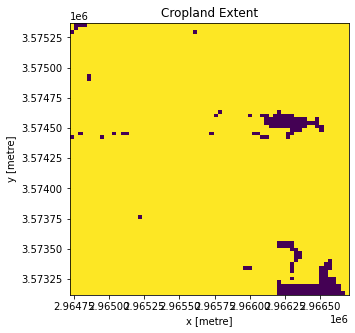

In [9]:
cm = dc.load(product=crop_mask,
            time=('2019'),
            measurements='mask',
            resampling='nearest', 
            like=ds.geobox).mask.squeeze()

cm.plot.imshow(add_colorbar=False, figsize=(5,5))
plt.title('Cropland Extent');

### Mask non-croplands

In [10]:
ds = ds.where(cm, np.nan)
ds_sentinel = ds_sentinel.where(cm, np.nan)

In [11]:
ds = calculate_indices(ds, 'NDVI', collection='c2', drop=False)
ds_sentinel = calculate_indices(ds_sentinel, 'NDVI', collection='s2', drop=False)

## Harmonize Landsat 8 with Sentinel-2 using Chastain et. al 2019

https://www.sciencedirect.com/science/article/pii/S0034425718305212?via%3Dihub

In [12]:
# multiplying the red band with slope and adding to intercept
slope = 1.0524
intercept = -0.00151
ds['red_chastain']  = (ds['red'] * slope) + intercept

In [13]:
# multiplying the nir band with slope and adding to intercept
slope = 0.8954
intercept = 0.0033
ds['nir_chastain']  = (ds['nir'] * slope) + intercept

### Recalcuate NDVI

In [14]:
ds['ndvi_chastain'] = (ds['nir_chastain']-ds['red_chastain'])/(ds['nir_chastain']+ds['red_chastain'])

### Reduce to 1D for plotting

In [15]:
ndvi_ls = ds.NDVI.mean(dim=['x','y']).compute()
ndvi_s2 = ds_sentinel.NDVI.mean(dim=['x','y']).compute()
ndvi_ls_chastain = ds.ndvi_chastain.mean(dim=['x','y']).compute()

### Plot

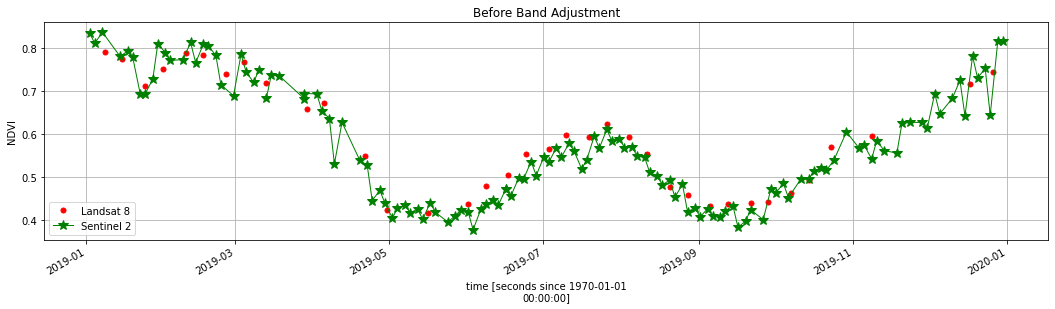

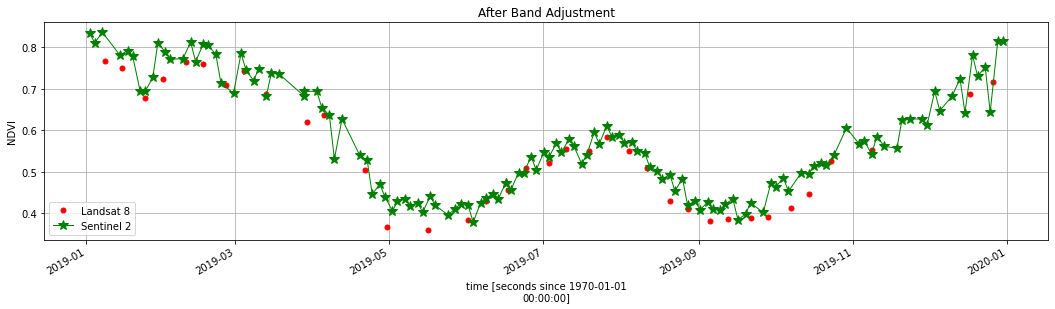

In [16]:
plt.figure(figsize=(18, 4))
ndvi_ls.plot(marker='.', lw=0, color='red', ms=10, label='Landsat 8')
ndvi_s2.plot(marker='*', lw=1, ms=10, color='green', label='Sentinel 2')
plt.legend()
plt.title('Before Band Adjustment')
plt.grid()

plt.figure(figsize=(18, 4))
ndvi_ls_chastain.plot(marker='.', lw=0, color='red', ms=10, label='Landsat 8')
ndvi_s2.plot(marker='*', lw=1, ms=10, color='green', label='Sentinel 2')
plt.legend()
plt.title('After Band Adjustment')

plt.grid()
plt.show()

## Harmonize Landsat 8 with Sentinel-2 using Zhang et. al 2018

https://www.sciencedirect.com/science/article/pii/S0034425718301883


NDVI regression coefficents (derived from surface reflectance data), study area was over South Africa

* LS8 OLI = 0.0185 + 0.9566 MSI
* S2 MSI = 0.0016 + 1.0016 OLI

In [17]:
ndvi_ls_zhang = 0.0016 + 1.0016*ds['NDVI']

In [18]:
ndvi_ls_zhang = ndvi_ls_zhang.mean(dim=['x','y']).compute()

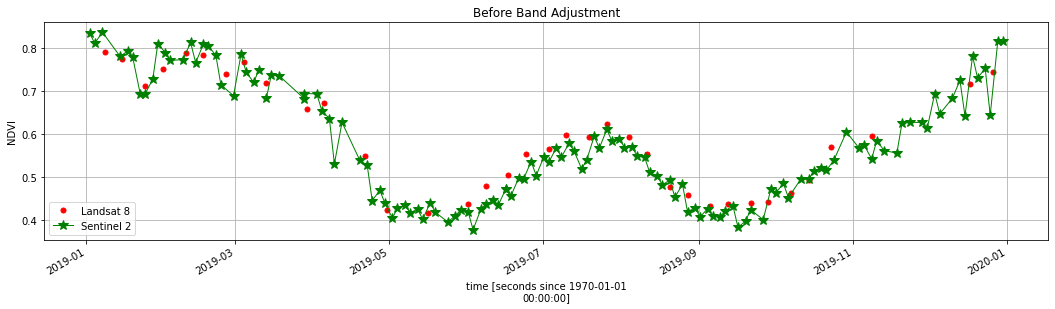

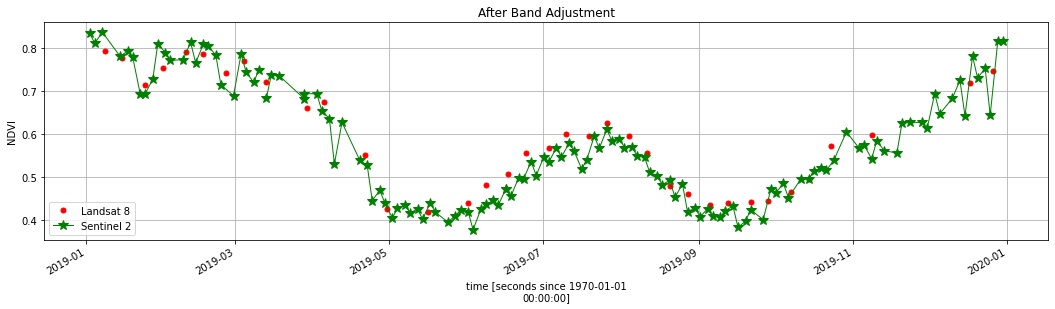

In [19]:
plt.figure(figsize=(18, 4))
ndvi_ls.plot(marker='.', lw=0, color='red', ms=10, label='Landsat 8')
ndvi_s2.plot(marker='*', lw=1, ms=10, color='green', label='Sentinel 2')
plt.legend()
plt.title('Before Band Adjustment')
plt.grid()

plt.figure(figsize=(18, 4))
ndvi_ls_zhang.plot(marker='.', lw=0, color='red', ms=10, label='Landsat 8')
ndvi_s2.plot(marker='*', lw=1, ms=10, color='green', label='Sentinel 2')
plt.legend()
plt.title('After Band Adjustment')

plt.grid()